# Chirp Function

We will deal with linear frequency modulated (LFM) radars and ionosondes. These systems transmit "chirps," i.e. rising tones that linearly increase in frequency over time. They can be expressed as

$$ y(t) = e^{j \omega(t) t}$$

$$\omega(t) = mt + b$$

where $m$ and $b$ are constants.

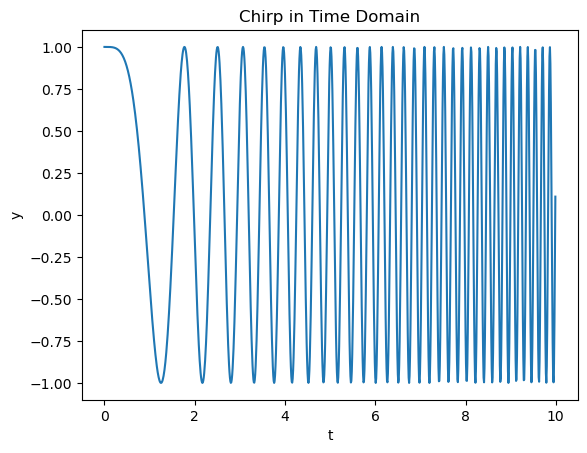

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fs = 100
N = 1000

t = np.arange(N) / float(fs)
w = t / 50
y = np.cos(w * fs *t)

plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Chirp in Time Domain')
plt.show()

Using bigger, more realistic values to avoid plotting artifacts later on,

In [2]:
fs = 20e3
N = 1e5

A = 2 * np.sqrt(2)
w = 2 * np.pi * 3e3

t = np.arange(N) / float(fs)
w = t / 4
y = A * np.cos(w * fs * t)

## Spectrum of Chirp

If we take the FFT of $y(t)$, what do we expect?

*(Computing this might take a minute)*

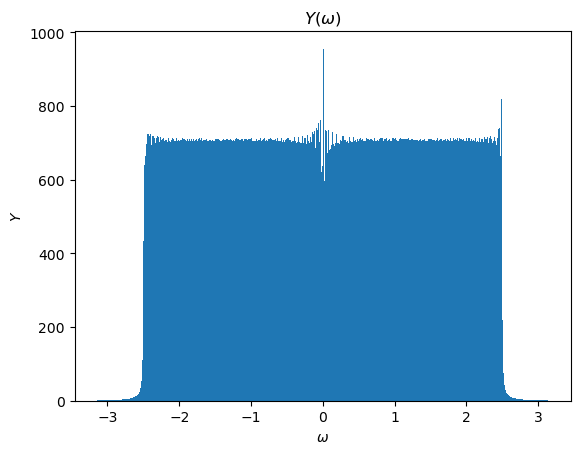

In [3]:
freq = np.fft.fftfreq(t.shape[-1])
omega = 2 * np.pi * freq
Y = np.fft.fft(y)

plt.bar(omega, np.abs(Y), width=2 * np.pi / N)
plt.xlabel('$\omega$')
plt.ylabel('$Y$')
plt.title('$Y(\omega)$')

plt.show()

There isn't a clear peak, because the signal has frequency components ranging from $\omega(0) = 0$ to $\omega(10) = 1/5$.

**Question:** How can we visualize the rising tone using our knowledge of the FFT?

**Answer:** By chopping up the time-domain signal into chunks, taking the FFT of each chunk, and seeing how the FFT changes from chunk to chunk. This is called the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

## Short-Time Fourier Transform

Chopping up the $N$ samples of $y$ into overlapping chunks of length $N/100$, we get

In [4]:
M = int(N / 1000)
chunks_y = []
chunks_t = []

for i in range(M):
    chunk_y = y[i * M : (i + 1) * M]
    chunk_t = t[i * M : (i + 1) * M]
    
    chunks_y.append(chunk_y)
    chunks_t.append(chunk_t)

Visualizing the FFT of successive chunks, we see

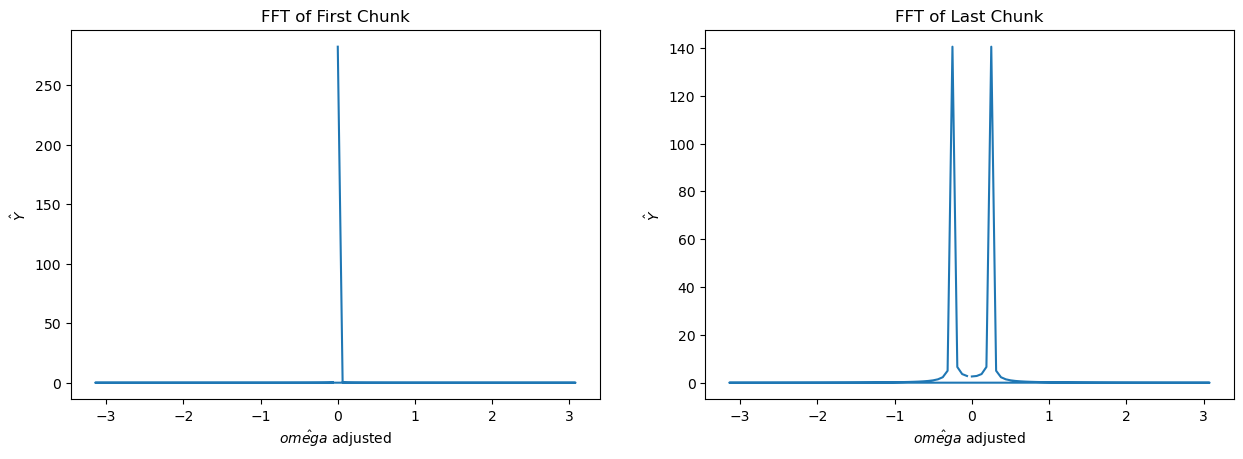

In [5]:
plt.figure().set_figwidth(15)

y_first = chunks_y[0]
y_last = chunks_y[-1]

freq = np.fft.fftfreq(y_first.shape[-1])
omega = 2 * np.pi * freq

Spec_first = np.fft.fft(y_first)
Spec_last = np.fft.fft(y_last)

idxs = np.abs(omega) < 5 # restrict plotting to low frequencies

plt.subplot(1, 2, 1)
plt.plot(omega[idxs], np.abs(Spec_first[idxs]))
plt.xlabel('$\hat{omega}$ adjusted')
plt.ylabel('$\hat{Y}$')
plt.title('FFT of First Chunk')

plt.subplot(1, 2, 2)
plt.plot(omega[idxs], np.abs(Spec_last[idxs]))
plt.xlabel('$\hat{omega}$ adjusted')
plt.ylabel('$\hat{Y}$')
plt.title('FFT of Last Chunk')

plt.show()

As we can see, the dominant frequency changed from $\omega(0) = 0$ to $\omega(10) = 2.5$ in the original spectrum, and squeezed to appear even smaller by the downsampling of the STFT.

To visualize this signal's frequency response over time, we can aggregate the FFTs of all the chunks into a 3D plot. Here, the $x$ axis represents the chunk index, the $y$ axis is the FFT frequency bin index, and the $z$ axis represents the magnitude of the FFT value at the given frequency within the given chunk. We can even re-scale so that the $x$ axis is in seconds and the $y$ axis is in Hz. This type of plot is called a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), and is implemented by `scipy`. For plotting convenience, we'll plot in 2D and represent the $z$ axis using a colormap.

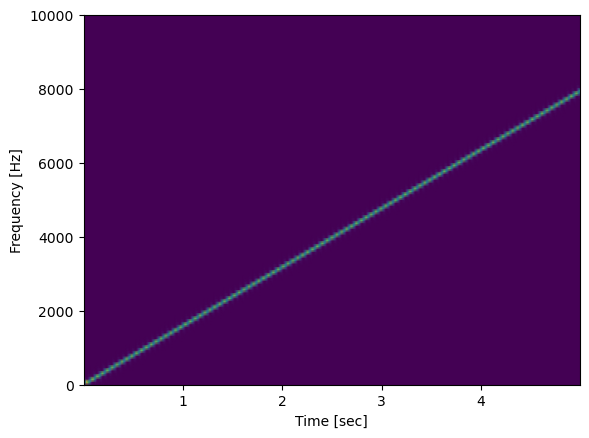

In [6]:
from scipy import signal

f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()